In [216]:


# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
     

# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)

In [218]:

from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV
     

from datetime import datetime
import os
import random
import gc

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\users\\fct\\appdata\\local\\programs\\python\\python311\\lib\\site-packages\\numpy-1.25.1.dist-info\\METADATA'

In [180]:
## same item id is same as movie id, item id column is renamed as movie id
column_names1 = ['user id','movie id','rating','timestamp']
dataset = pd.read_csv('./data/ml-100k/u.data', sep='\t',header=None,names=column_names1)
dataset.head() 

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [181]:

len(dataset), max(dataset['movie id']),min(dataset['movie id'])

(100000, 1682, 1)

In [182]:
d = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')
column_names2
     

['movie id',
 'movie title',
 'release date',
 'video release date',
 'IMDb URL',
 'unknown',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [183]:
items_dataset = pd.read_csv('./data/ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
items_dataset
     

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [184]:
movie_dataset = items_dataset[['movie id','movie title']]
movie_dataset.head()
     

,movie id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [185]:
## looking at length of original items_dataset and length of unique combination of rows in items_dataset after removing movie id column
len(items_dataset.groupby(by=column_names2[1:])),len(items_dataset)

(1664, 1682)

In [186]:
merged_dataset = pd.merge(dataset, movie_dataset, how='inner', on='movie id')
merged_dataset.head()

,user id,movie id,rating,timestamp,movie title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [187]:
merged_dataset[(merged_dataset['movie title'] == 'Chasing Amy (1997)') & (merged_dataset['user id'] == 894)]

,user id,movie id,rating,timestamp,movie title
4800,894,246,4,882404137,Chasing Amy (1997)
22340,894,268,3,879896041,Chasing Amy (1997)


In [188]:

refined_dataset = merged_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


In [189]:

# num_users = len(refined_dataset.rating.unique())
# num_items = len(refined_dataset.movieId.unique())
num_users = len(refined_dataset['user id'].value_counts())
num_items = len(refined_dataset['movie title'].value_counts())
print('Unique number of users in the dataset: {}'.format(num_users))
print('Unique number of movies in the dataset: {}'.format(num_items))


Unique number of users in the dataset: 943
Unique number of movies in the dataset: 1664


In [190]:
rating_count_df = pd.DataFrame(refined_dataset.groupby(['rating']).size(), columns=['count'])
rating_count_df

,count
rating,
1.0,6083
1.5,3
2.0,11334
2.5,6
3.0,27060
3.5,19
4.0,34042
4.5,16
5.0,21130


Text(0, 0.5, 'number of ratings')

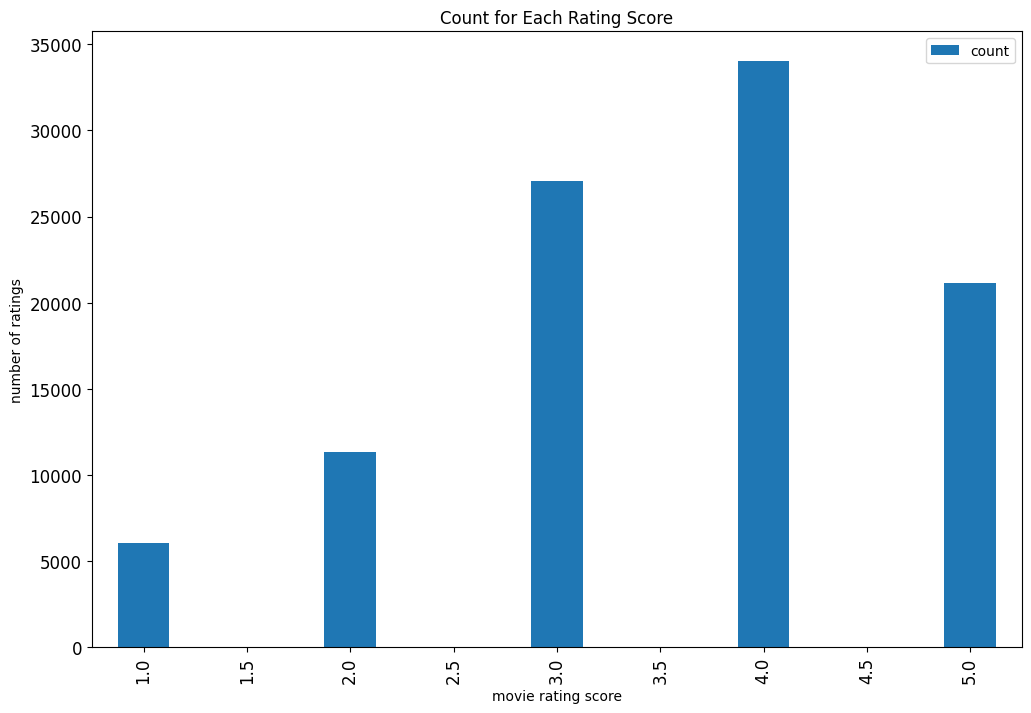

In [191]:
ax = rating_count_df.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    fontsize=12)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [192]:
total_count = num_items * num_users
zero_count = total_count-refined_dataset.shape[0]
zero_count

1469459

In [193]:
# Create a new DataFrame with the data to be added
new_row = pd.DataFrame({'count': [zero_count], 'log_count': [np.log(zero_count)]})

# Reset the index of 'new_row'
new_row.reset_index(drop=True, inplace=True)

# Concatenate the new DataFrame with the existing 'rating_count_df'
rating_count_df = pd.concat([rating_count_df, new_row], verify_integrity=True).sort_index()

In [194]:

# add log count
rating_count_df['log_count'] = np.log(rating_count_df['count'])
rating_count_df

,count,log_count
0.0,1469459,14.200405
1.0,6083,8.713253
1.5,3,1.098612
2.0,11334,9.335562
2.5,6,1.791759
3.0,27060,10.205812
3.5,19,2.944439
4.0,34042,10.435350
4.5,16,2.772589
5.0,21130,9.958449


In [195]:
rating_count_df = rating_count_df.reset_index().rename(columns={'index': 'rating score'})
rating_count_df

,rating score,count,log_count
0,0.0,1469459,14.200405
1,1.0,6083,8.713253
2,1.5,3,1.098612
3,2.0,11334,9.335562
4,2.5,6,1.791759
5,3.0,27060,10.205812
6,3.5,19,2.944439
7,4.0,34042,10.435350
8,4.5,16,2.772589
9,5.0,21130,9.958449


Text(0, 0.5, 'number of ratings')

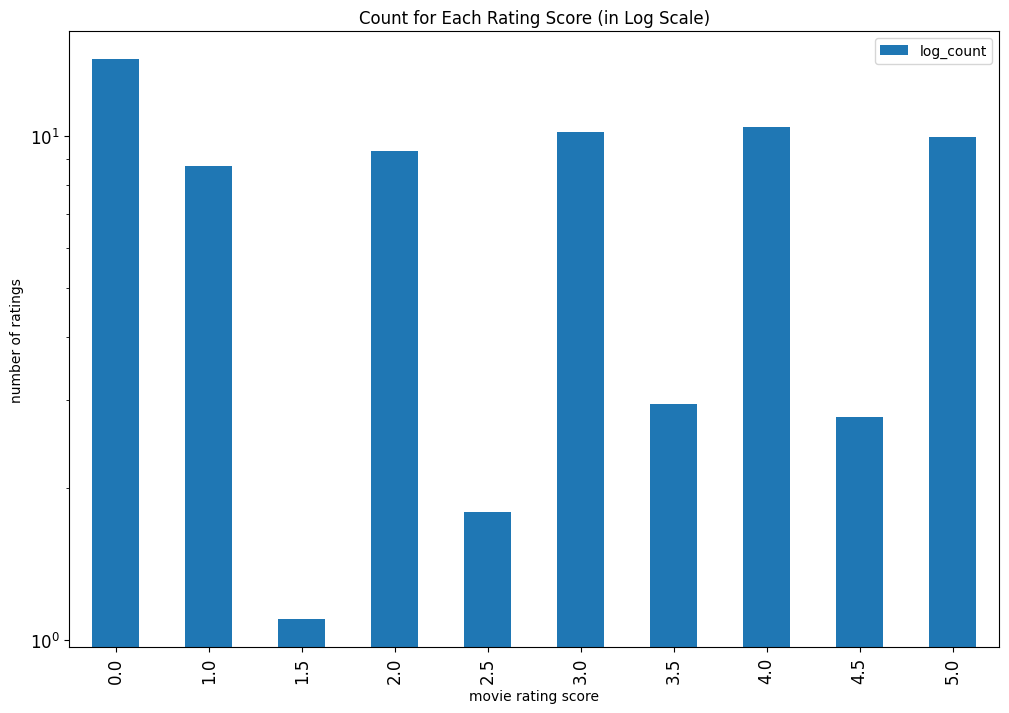

In [196]:

ax = rating_count_df.plot('rating score', 'log_count', 'bar', figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [197]:
refined_dataset.head()

,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


In [198]:
# get rating frequency
movies_count_df = pd.DataFrame(refined_dataset.groupby('movie title').size(), columns=['count'])
movies_count_df.head()
     

,count
movie title,
'Til There Was You (1997),9
1-900 (1994),5
101 Dalmatians (1996),109
12 Angry Men (1957),125
187 (1997),41


Text(0, 0.5, 'number of ratings')

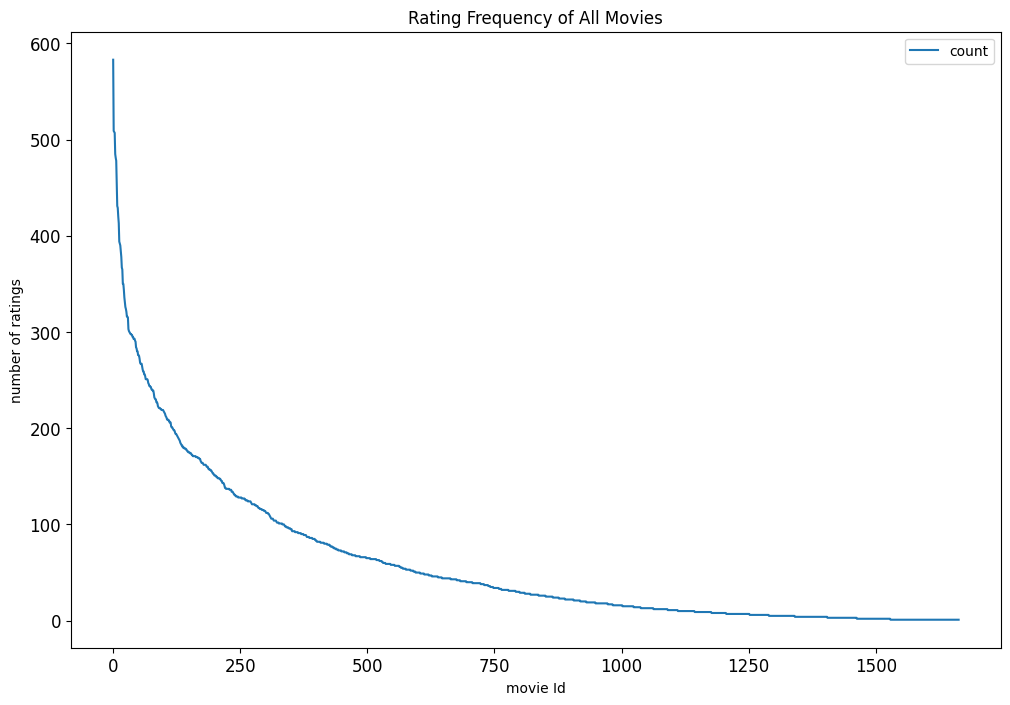

In [199]:
# plot rating frequency of all movies
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

In [200]:

# pivot and create movie-user matrix
user_to_movie_df = refined_dataset.pivot(
    index='user id',
     columns='movie title',
      values='rating').fillna(0)

user_to_movie_df.head()

movie title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


In [201]:

# transform matrix to scipy sparse matrix
user_to_movie_sparse_df = csr_matrix(user_to_movie_df.values)
user_to_movie_sparse_df

<943x1664 sparse matrix of type '<class 'numpy.float64'>'
	with 99693 stored elements in Compressed Sparse Row format>

In [202]:

knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_to_movie_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [203]:
## function to find top n similar users of the given input user 
def get_similar_users(user, n = 5):
  ## input to this function is the user and number of top similar users you want.

  knn_input = np.asarray([user_to_movie_df.values[user-1]])  #.reshape(1,-1)
  # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
  distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
  
  print("Top",n,"users who are very much similar to the User-",user, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
  return indices.flatten()[1:] + 1, distances.flatten()[1:]


In [204]:

from pprint import pprint
user_id = 844
print(" Few of movies seen by the User:")
pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title'])[:10])
similar_user_list, distance_list = get_similar_users(user_id,5)

 Few of movies seen by the User:
['Air Force One (1997)',
 'Aladdin (1992)',
 'Aliens (1986)',
 'Army of Darkness (1993)',
 'Batman (1989)',
 'Beauty and the Beast (1991)',
 'Blade Runner (1982)',
 'Braveheart (1995)',
 'Brazil (1985)',
 'Chain Reaction (1996)']
Top 5 users who are very much similar to the User- 844 are: 
 
1 . User: 484 separated by distance of 0.5339099946749888
2 . User: 521 separated by distance of 0.5533990717053976
3 . User: 249 separated by distance of 0.5591879076141322
4 . User: 622 separated by distance of 0.5598727142103515
5 . User: 757 separated by distance of 0.5689182694075132


In [205]:
#we define weights to ratings by each similar user based on the thier distance from the input user. 
#Defining these weights would give us the accurate recommendations by 
#eliminating the chance of decision manipulation by the users who are relatively very far from the input user.

similar_user_list, distance_list

(array([484, 521, 249, 622, 757], dtype=int64),
 array([0.53390999, 0.55339907, 0.55918791, 0.55987271, 0.56891827]))

In [206]:
weightage_list = distance_list/np.sum(distance_list)
weightage_list

array([0.19238004, 0.1994024 , 0.20148825, 0.201735  , 0.20499432])

In [207]:
mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
mov_rtngs_sim_users

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [208]:

movies_list = user_to_movie_df.columns
movies_list

Index([''Til There Was You (1997)', '1-900 (1994)', '101 Dalmatians (1996)',
       '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)',
       ...
       'Yankee Zulu (1994)', 'Year of the Horse (1997)', 'You So Crazy (1994)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Poisoner's Handbook, The (1995)',
       'Zeus and Roxanne (1997)', 'unknown',
       'Á köldum klaka (Cold Fever) (1994)'],
      dtype='object', name='movie title', length=1664)

In [209]:
print("Weightage list shape:", len(weightage_list))
print("mov_rtngs_sim_users shape:", mov_rtngs_sim_users.shape)
print("Number of movies:", len(movies_list))

Weightage list shape: 5
mov_rtngs_sim_users shape: (5, 1664)
Number of movies: 1664


In [210]:

weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
weightage_list.shape

(5, 1664)

In [211]:
new_rating_matrix = weightage_list*mov_rtngs_sim_users
mean_rating_list = new_rating_matrix.sum(axis =0)
mean_rating_list

array([0., 0., 0., ..., 0., 0., 0.])

In [212]:
from pprint import pprint
def recommend_movies(n):
  n = min(len(mean_rating_list),n)
  # print(np.argsort(mean_rating_list)[::-1][:n])
  pprint(list(movies_list[np.argsort(mean_rating_list)[::-1][:n]]))


     

print("Movies recommended based on similar users are: ")
recommend_movies(10)
     

Movies recommended based on similar users are: 
['2001: A Space Odyssey (1968)',
 'Usual Suspects, The (1995)',
 'North by Northwest (1959)',
 'Fargo (1996)',
 'Star Wars (1977)',
 'Shining, The (1980)',
 'Clockwork Orange, A (1971)',
 'Godfather, The (1972)',
 'Return of the Jedi (1983)',
 'Taxi Driver (1976)']


In [213]:


def filtered_movie_recommendations(n):
  
  first_zero_index = np.where(mean_rating_list == 0)[0][-1]
  sortd_index = np.argsort(mean_rating_list)[::-1]
  sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
  n = min(len(sortd_index),n)
  movies_watched = list(refined_dataset[refined_dataset['user id'] == user_id]['movie title'])
  filtered_movie_list = list(movies_list[sortd_index])
  count = 0
  final_movie_list = []
  for i in filtered_movie_list:
    if i not in movies_watched:
      count+=1
      final_movie_list.append(i)
    if count == n:
      break
  if count == 0:
    print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
  else:
    pprint(final_movie_list)

     

filtered_movie_recommendations(10)
     

['2001: A Space Odyssey (1968)',
 'North by Northwest (1959)',
 'Shining, The (1980)',
 'Godfather, The (1972)',
 'Taxi Driver (1976)',
 'Titanic (1997)',
 'Alien (1979)',
 'Fugitive, The (1993)',
 'Scream (1996)',
 'Back to the Future (1985)']


In [214]:
from pprint import pprint

def recommender_system(user_id, n_similar_users, n_movies): #, user_to_movie_df, knn_model):
  
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
  print("")

  # def get_similar_users(user, user_to_movie_df, knn_model, n = 5):
  def get_similar_users(user, n = 5):
    
    knn_input = np.asarray([user_to_movie_df.values[user-1]])
    
    distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
    
    print("Top",n,"users who are very much similar to the User-",user, "are: ")
    print(" ")

    for i in range(1,len(distances[0])):
      print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
    print("")
    return indices.flatten()[1:] + 1, distances.flatten()[1:]


  def filtered_movie_recommendations(n = 10):
  
    first_zero_index = np.where(mean_rating_list == 0)[0][-1]
    sortd_index = np.argsort(mean_rating_list)[::-1]
    sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
    n = min(len(sortd_index),n)
    movies_watched = list(refined_dataset[refined_dataset['user id'] == user_id]['movie title'])
    filtered_movie_list = list(movies_list[sortd_index])
    count = 0
    final_movie_list = []
    for i in filtered_movie_list:
      if i not in movies_watched:
        count+=1
        final_movie_list.append(i)
      if count == n:
        break
    if count == 0:
      print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
    else:
      pprint(final_movie_list)

  similar_user_list, distance_list = get_similar_users(user_id,n_similar_users)
  weightage_list = distance_list/np.sum(distance_list)
  mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
  movies_list = user_to_movie_df.columns
  weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
  new_rating_matrix = weightage_list*mov_rtngs_sim_users
  mean_rating_list = new_rating_matrix.sum(axis =0)
  print("")
  print("Movies recommended based on similar users are: ")
  print("")
  filtered_movie_recommendations(n_movies)

In [215]:
print("Enter user id")
user_id= int(input())
print("number of similar users to be considered")
sim_users = int(input())
print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,sim_users,n_movies)
# recommender_system(300, 15,15)

Enter user id


ValueError: invalid literal for int() with base 10: 'dad'

In [ ]:
# pivot and create movie-user matrix
movie_to_user_df = refined_dataset.pivot(
     index='movie title',
   columns='user id',
      values='rating').fillna(0)

movie_to_user_df.head()

In [ ]:
# transform matrix to scipy sparse matrix
movie_to_user_sparse_df = csr_matrix(movie_to_user_df.values)
movie_to_user_sparse_df
     

In [ ]:
movies_list = list(movie_to_user_df.index)
movies_list[:10]

In [ ]:

movie_dict = {movie : index for index, movie in enumerate(movies_list)}
print(movie_dict)

In [ ]:
case_insensitive_movies_list = [i.lower() for i in movies_list]
     
knn_movie_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_movie_model.fit(movie_to_user_sparse_df)

In [ ]:
## function to find top n similar users of the given input user 
def get_similar_movies(movie, n = 10):
  ## input to this function is the movie and number of top similar movies you want.
  index = movie_dict[movie]
  knn_input = np.asarray([movie_to_user_df.values[index]])
  n = min(len(movies_list)-1,n)
  distances, indices = knn_movie_model.kneighbors(knn_input, n_neighbors=n+1)
  
  print("Top",n,"movies which are very much similar to the Movie-",movie, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(movies_list[indices[0][i]])
  

In [ ]:
from pprint import pprint
movie_name = '101 Dalmatians (1996)'

get_similar_movies(movie_name,15)
     

In [ ]:
# function which takes input and returns suggestions for the user

def get_possible_movies(movie):

    temp = ''
    possible_movies = case_insensitive_movies_list.copy()
    for i in movie :
      out = []
      temp += i
      for j in possible_movies:
        if temp in j:
          out.append(j)
      if len(out) == 0:
          return possible_movies
      out.sort()
      possible_movies = out.copy()

    return possible_movies
     

In [ ]:
class invalid(Exception):
    pass

def spell_correction():
    
    try:

      movie_name = input("Enter the Movie name: ")
      movie_name_lower = movie_name.lower()
      if movie_name_lower not in case_insensitive_movies_list :
        raise invalid
      else :
        # movies_list[case_insensitive_country_names.index(movie_name_lower)]
        num_recom = int(input("Enter Number of movie recommendations needed: "))
        get_similar_movies(movies_list[case_insensitive_movies_list.index(movie_name_lower)],num_recom)

    except invalid:

      possible_movies = get_possible_movies(movie_name_lower)

      if len(possible_movies) == len(movies_list) :
        print("Movie name entered is does not exist in the list ")
      else :
        indices = [case_insensitive_movies_list.index(i) for i in possible_movies]
        print("Entered Movie name is not matching with any movie from the dataset . Please check the below suggestions :\n",[movies_list[i] for i in indices])
        spell_correction()

     

spell_correction()

In [ ]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_to_user_df.shape[0] * movie_to_user_df.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_to_user_df==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))
     

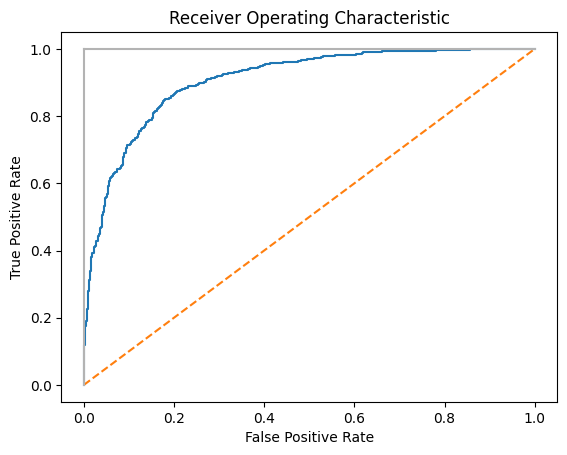

In [22]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split


# Create feature matrix and target vector
features, target = make_classification(n_samples=10000,
n_features=10,
n_classes=2,
n_informative=3,
random_state=3)
# Split into training and test sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=1)
# Create classifier
logit = LogisticRegression()
# Train model
logit.fit(features_train, target_train)

# Get predicted probabilities
target_probabilities = logit.predict_proba(features_test)[:,1]
# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold =roc_curve(target_test,target_probabilities)
# Plot ROC curve
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()